In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.image as img
import matplotlib.patches as patches
from scipy.ndimage.filters import gaussian_filter

In [7]:
p = Path('../gazecapture/')

In [4]:
def frames_dir(case): return p / case / 'frames'
def get_json(i, fn): 
    j_fp = p / i / fn
    with open(j_fp) as f: return json.load(f)
    
def get_info(i): return get_json(i, 'info.json')
def get_screen_info(i): return get_json(i, 'screen.json')
def get_frame_info(i): return get_json(i, 'frames.json')
def get_dot_info(i): return get_json(i, 'dotInfo.json')
def get_face_info(i): return get_json(i, 'appleFace.json')
def get_image(i, image_filename): return img.imread(p/i/'frames'/image_filename)
def get_eye_info(i): return get_json(i, 'appleLeftEye.json'), get_json(i, 'appleRightEye.json')

# Heatmap of X, Y cords
def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

# Number Analysis

In [9]:
train = 0
val = 0
test = 0
train_frames, val_frames, test_frames = 0, 0, 0
num_frames = 0
max_frames, min_frames = 100, 100
for x in p.iterdir(): 
    info = get_info(x.name)
    dset = info['Dataset']
    num_frames += info['TotalFrames']
    max_frames = max(max_frames, info['TotalFrames'])
    min_frames = min(min_frames, info['TotalFrames'])
    if dset == 'train': 
        train += 1
        train_frames += info['TotalFrames']
    elif dset == 'val': 
        val += 1
        val_frames += info['TotalFrames']
    elif dset == 'test': 
        test += 1
        test_frames += info['TotalFrames']
print("Number of (train, val, test):", (train, val, test))
print("Number of Frames for (train, val, test):", (train_frames, val_frames, test_frames))
print("(total_frames, max_frames, min_frames):", (num_frames, max_frames, min_frames))

Number of (train, val, test): (1124, 42, 124)
Number of Frames for (train, val, test): (1785966, 73476, 239820)
(total_frames, max_frames, min_frames): (2099262, 3590, 4)


<BarContainer object of 3 artists>

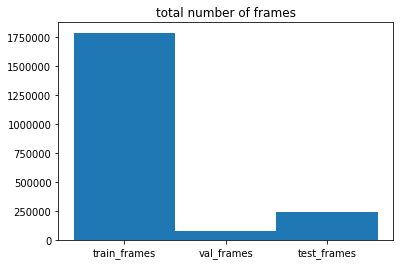

In [5]:
fig = plt.figure()                                                               
ax = fig.gca()  #get current axes
plt.title('total number of frames')
ax.bar(['train_frames', 'val_frames', 'test_frames'], [train_frames, val_frames, test_frames], 1, align='center')

<BarContainer object of 3 artists>

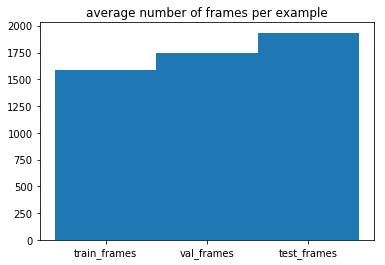

In [11]:
fig = plt.figure()                                                               
ax = fig.gca()  #get current axes
plt.title('average number of frames per example')
ax.bar(['train_frames', 'val_frames', 'test_frames'], [train_frames/train, val_frames/val, test_frames/test], 1, align='center')

In [39]:
train_frames/num_frames, val_frames/num_frames, test_frames/num_frames

(0.8507589810133276, 0.035000871734923986, 0.11424014725174847)

In [57]:
orientation = ['portrait', 'portrait_upsidedown', 'landscape_homeright', 'landscape_homeleft']
frame_count = np.array([0, 0, 0, 0])
for x in p.iterdir(): 
    info = get_screen_info(x.name)
    o = info['Orientation']
    unique, count = np.unique(o, return_counts=True)
    for i, val in enumerate(unique): frame_count[val-1] += count[i]

array([701703,  81265, 641305, 674989])

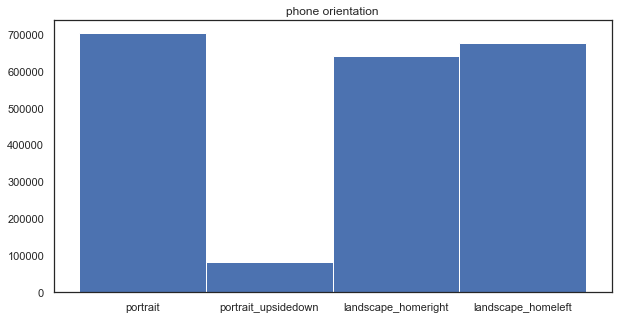

In [75]:
fig = plt.figure(figsize=(10, 5))                                                               
ax = fig.gca()  #get current axes
plt.title('phone orientation')
ax.bar(orientation, frame_count, 1, align='center')
frame_count

In [8]:
# visualize training data sizes
def plot(shapes_to_n):
    plt.bar(range(len(shapes_to_n)), list(shapes_to_n.values()), align='center')
    plt.xticks(range(len(shapes_to_n)), list(shapes_to_n.keys()))
    plt.xlabel('dimension')
    plt.ylabel('# of frames')
    plt.show()
    
shapes = {}
for f in p.iterdir():
    i = f.name
    H, W = get_screen_info(i)['H'], get_screen_info(i)['W']
    O = get_screen_info(i)["Orientation"]
    for h, w, o in zip(H, W, O):
        if o == 1: # portrait only
            shape = str((h, w))
            if shape in shapes: shapes[shape] += 1
            else: shapes[shape] = 1

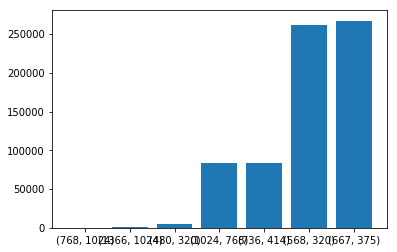

[('(768, 1024)', 24),
 ('(1366, 1024)', 859),
 ('(480, 320)', 4934),
 ('(1024, 768)', 83673),
 ('(736, 414)', 83679),
 ('(568, 320)', 261360),
 ('(667, 375)', 267174)]

In [9]:
# view possible the height / width 
import operator
sorted_shapes = sorted(shapes.items(), key=operator.itemgetter(1))
x, y = [], []
for i in sorted_shapes: x.append(i[0]) or y.append(i[1])
plt.bar(range(len(y)), list(y), align='center')
plt.xticks(range(len(x)), list(x))
plt.show()
sorted_shapes

# Heat Map Analysis

## Helpers

In [62]:
# record the X, Y cords for each H, W combination
shapes = {}
for f in p.iterdir():
    i = f.name
    X = np.array(get_dot_info(i)['XPts'])
    Y = np.array(get_dot_info(i)['YPts'])
    H, W = get_screen_info(i)['H'], get_screen_info(i)['W']
    O = get_screen_info(i)['Orientation']

    for x, y, h, w, o in zip(X, Y, H, W, O):
        if o != 2: # ignore upside down examples
            shape = str((h, w))
            if shape in shapes: 
                shapes[shape][0].append(x)
                shapes[shape][1].append(y)
            else: 
                shapes[shape] = [[x],[y], h, w]

In [ ]:
x, y = [], []
for f in p.iterdir():
    i = f.name
    X = get_dot_info(i)['XCam']
    Y = get_dot_info(i)['YCam']
    x = x + X
    y = y + Y

## Pixel Coordinates 

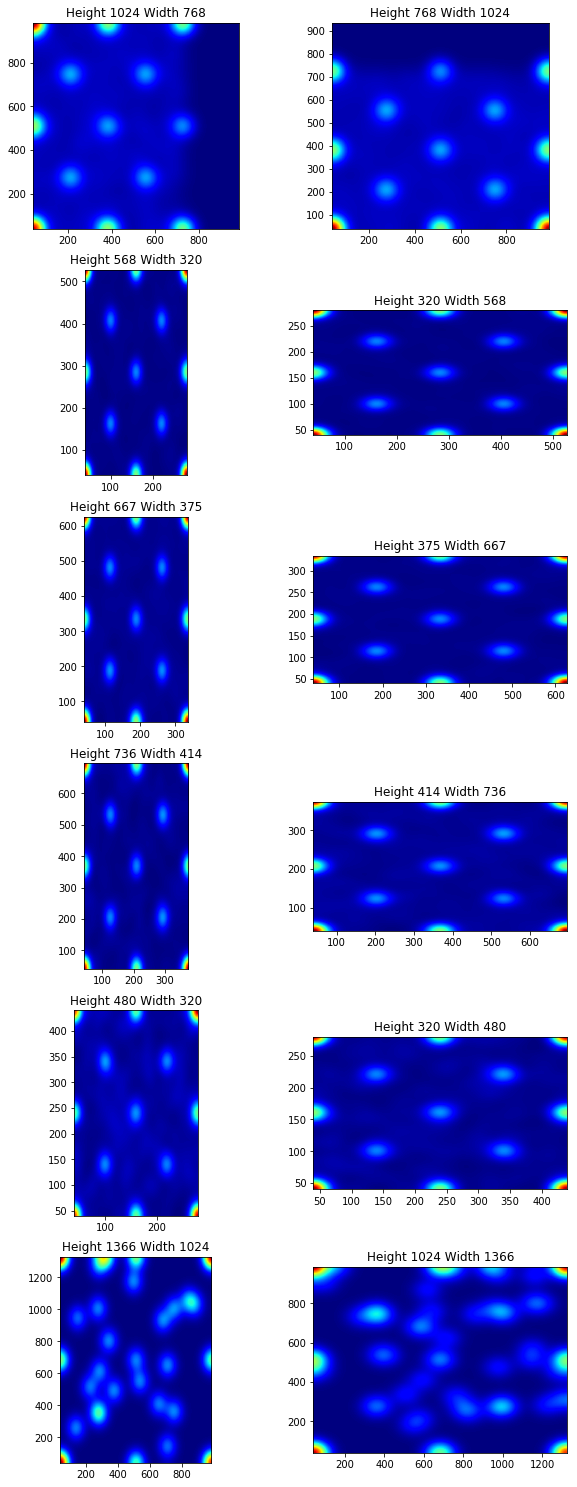

In [63]:
fig, axs = plt.subplots(6, 2)
fig.set_figheight(10)
fig.set_figwidth(10)
sigma = 40

for ax, shape in zip(axs.flatten(), shapes.keys()):
    x, y = shapes[shape][0], shapes[shape][1]
    h, w = shapes[shape][2], shapes[shape][3] 
    img, extent = myplot(x, y, sigma)
    ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    ax.set_title("Height {} Width {}".format(h, w))

plt.subplots_adjust(top=4, bottom=2)
plt.show()

## Camera Relative Pixel Coordinates 

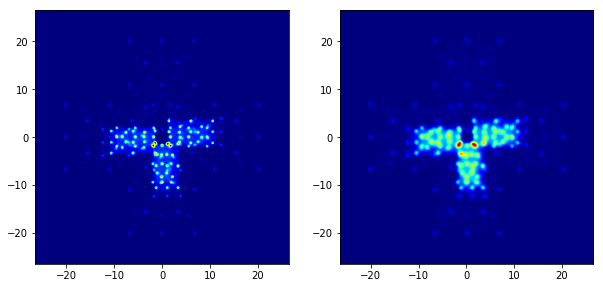

In [181]:
# Heatmaps for X, Y cord in cm with respect to Camera Position
# Camera will be at (0, 0)
fig, axs = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(10)
sigmas = [4, 7]

for ax, s in zip(axs.flatten(), sigmas):
    image, extent = myplot(x, y, s)
    ax.imshow(image, extent=extent, origin='lower', cmap=cm.jet)
plt.show()

# View Examples

## Helpers

In [5]:
device_df = pd.read_csv('apple_device_data.csv')
def get_device_data(deviceName):
    device_info = device_df[device_df['DeviceName'] == deviceName]
    # info converted to cm
    w = device_info['DeviceScreenWidthMm'] / 10
    h = device_info['DeviceScreenHeightMm'] / 10
#     ppc = device_info['DevicePixelsPerInch'] * 2.54
    edgeToCamX = device_info['DeviceCameraToScreenXMm'] / 10
    camToScreenY = device_info['DeviceCameraToScreenYMm'] / 10
    return h,  w, edgeToCamX, camToScreenY

In [19]:
def get_data_points(h, w, o, edgeToCamX, camToScreenY, x, y):
    # height and width layout
    px, py = [0, 0, w, w], [0, h, 0, h]
    # swap h and w if orientation if in landscape
    if o not in [1, 2]:
        px, py = py, px
        if o == 3: # homeright
            px = -1 * np.array(px)
            px = np.ndarray.tolist(px)
        
    # camera cord rel to h and w
    camera_x, camera_y = [0+edgeToCamX], [h+camToScreenY]
    if o not in [1, 2]:
        if o == 3: # homeright
            camera_x, camera_y = [-h-camToScreenY], [edgeToCamX]
        elif o == 4: # homeleft
            camera_x, camera_y = [h+camToScreenY], [w-edgeToCamX]
            
    # point relative to camera
    rel_pointx = x + camera_x[0]
    rel_pointy = y + camera_y[0]
            
    # bundle up all points into one list    
    y_points = py + camera_y + [rel_pointy]
    
    # plots are drawn from the perspective of the user
    # so we flip them so that they are move visually correct
    
    x_points = px + camera_x + [rel_pointx]
    x_points = -1 * np.array(x_points)
    x_points = np.ndarray.tolist(x_points)
    
    if o not in [1, 2]:
        y_points = -1 * np.array(y_points)
        y_points = np.ndarray.tolist(y_points)
    
    return x_points, y_points

## Examples

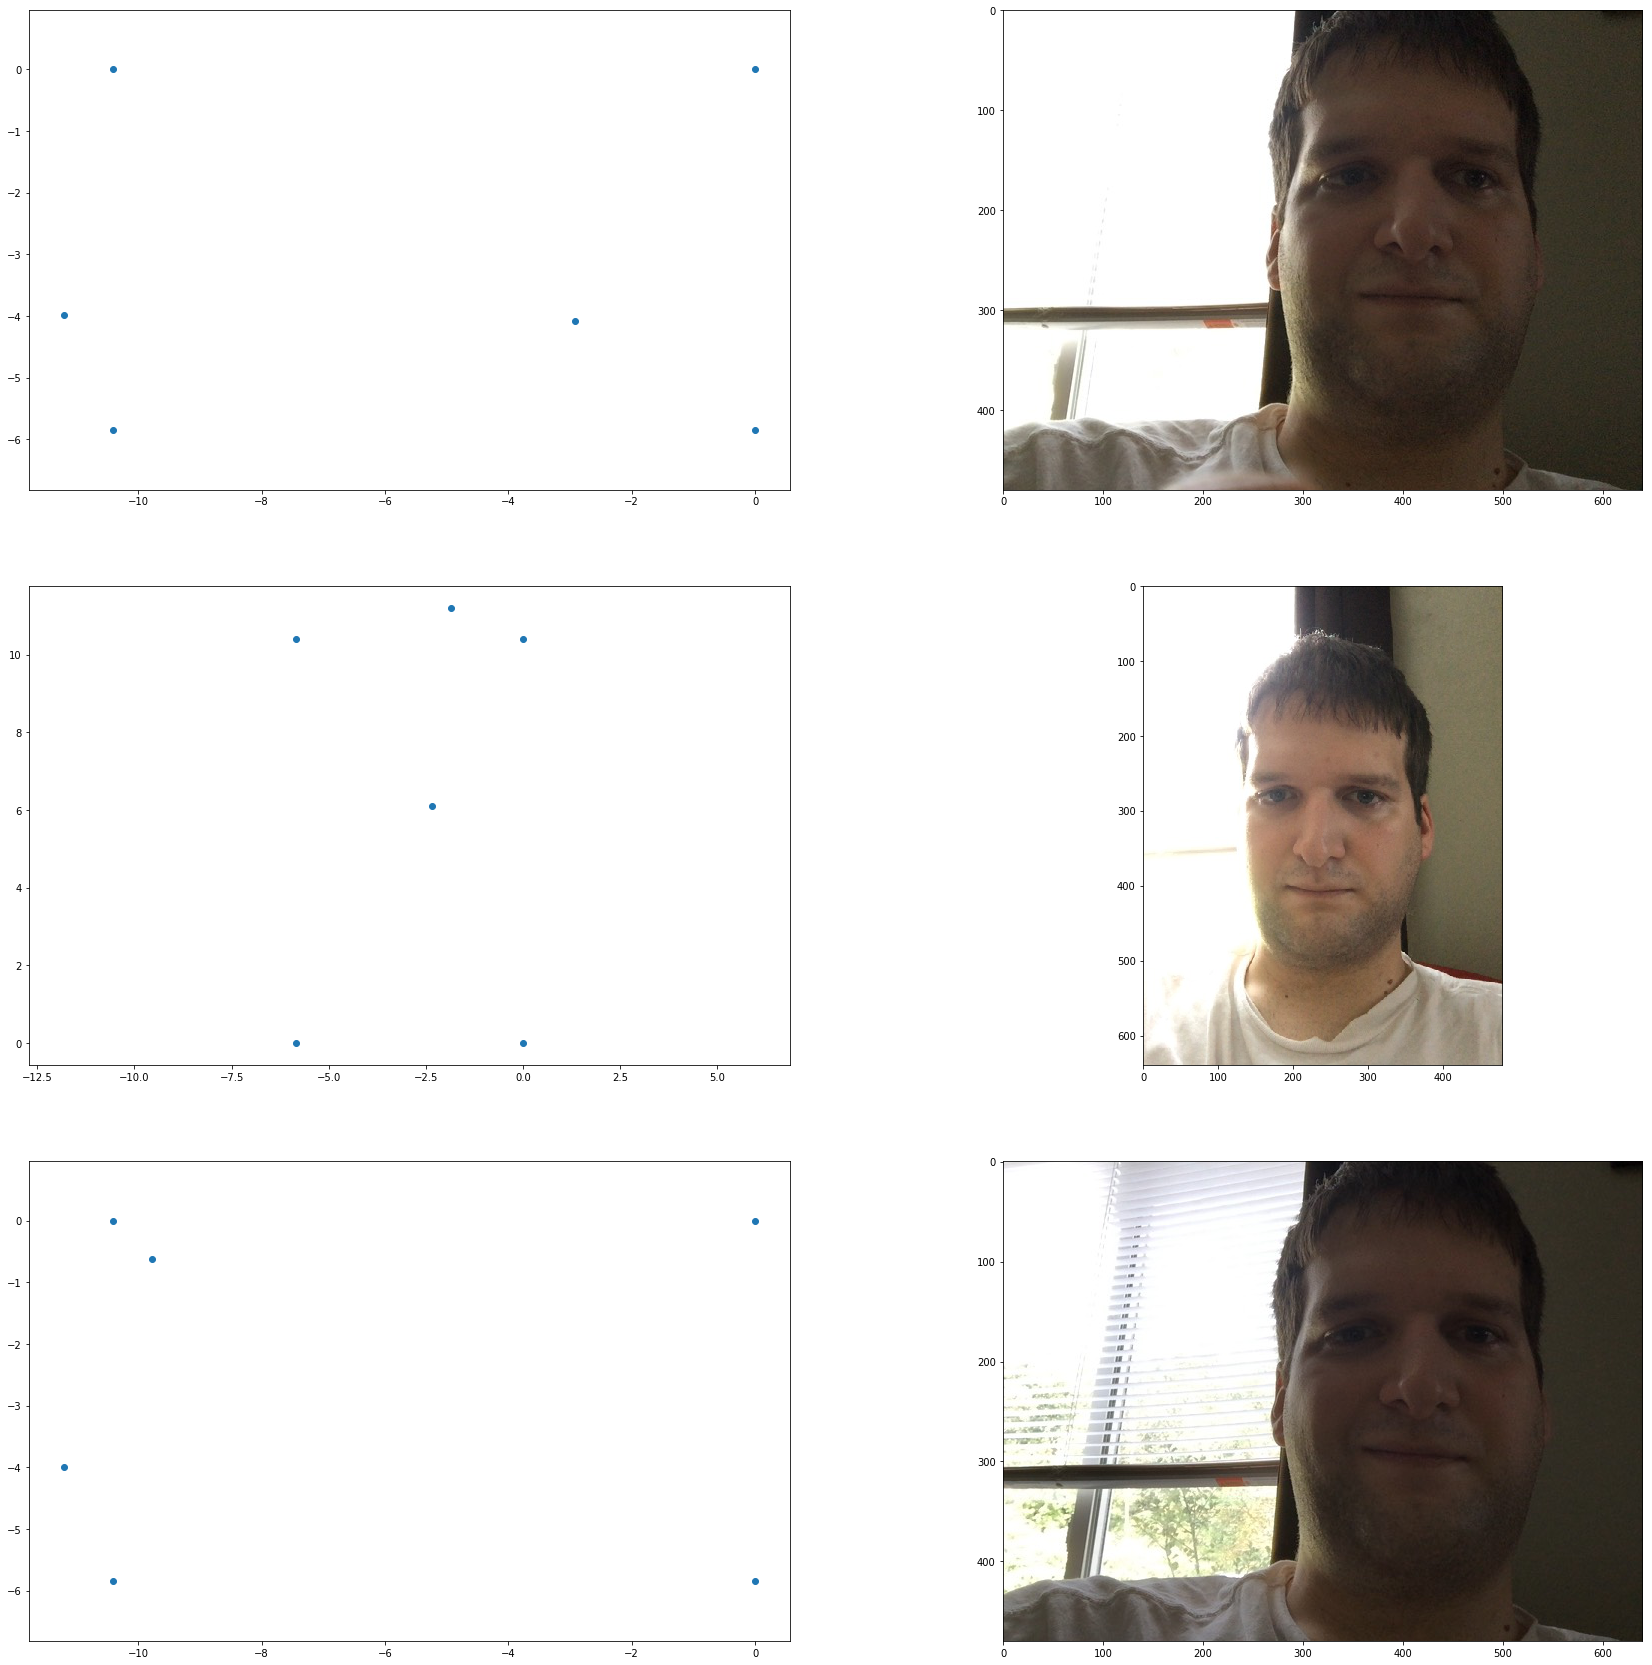

In [20]:
fig, axs = plt.subplots(3, 2)
fig.set_figheight(30)
fig.set_figwidth(30)

i = '00194'
# fig, axs = plt.subplots(1, 2)
frames = get_frame_info(i)
dot = get_dot_info(i)
screen = get_screen_info(i)
info = get_info(i)
totalFrames = info['TotalFrames']
deviceName = info['DeviceName']
O = screen['Orientation']
XCAM, YCAM = dot['XCam'], dot['YCam']
h, w, edgeToCamX, camToScreenY = get_device_data(deviceName)

for j, ax in enumerate(axs.flatten()):
    if j % 2:
        f_img = get_image(i, frames[frame])
        ax.imshow(f_img)
    else:
        frame = np.random.randint(0, totalFrames)
        xcam, ycam = XCAM[frame], YCAM[frame]
        o = O[frame]
        x, y = get_data_points(h, w, o, edgeToCamX, camToScreenY, xcam, ycam)
        ax.scatter(x, y)
        ax.axis('equal')
plt.show()